# modAL active learning with sklearn GP

In [18]:
! pip install modAL-python
! pip install scikit-learn

ModuleNotFoundError: No module named 'modAL'

/usr/local/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

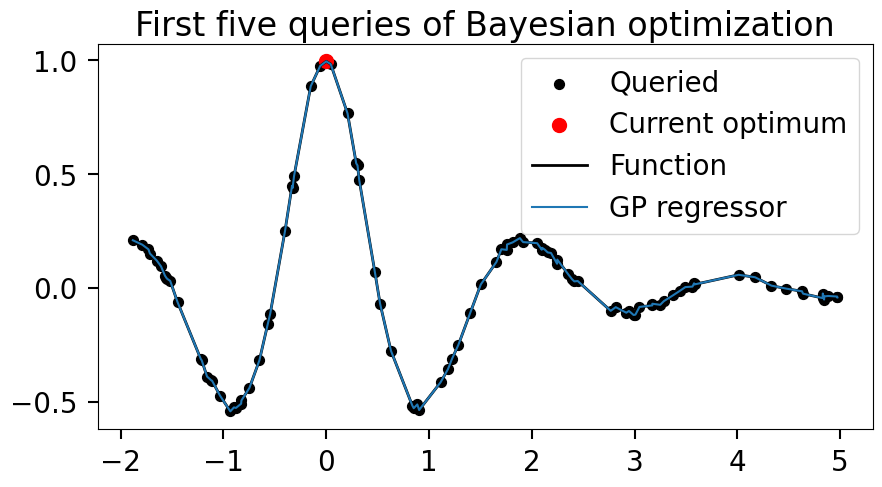

/usr/local/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The opti

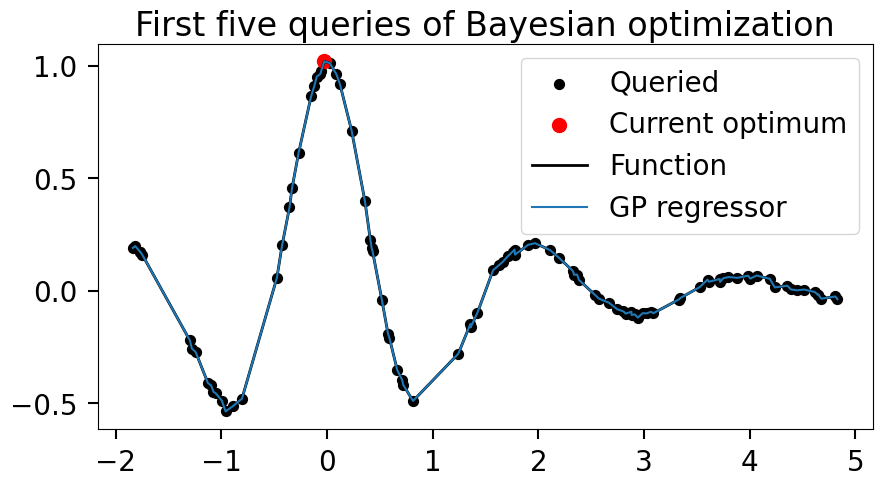

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI

import numpy as np


from example_datasets import Dataset1
#
dataset_1 = Dataset1(noise_sigma=0.01)
X, y = dataset_1.sample(100)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# sort the data
idx = np.argsort(X.ravel())
X = X[idx]
y = y[idx]

X_initial, y_initial = X[10].reshape(1, -1), y[10].reshape(1, -1)




# defining the kernel for the Gaussian process
kernel = Matern(length_scale=1.0)
regressor = GaussianProcessRegressor(kernel=kernel)
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X, y_training=y,
    query_strategy=max_EI
)

# Bayesian optimization
for n_query in range(5):
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))


y_pred, y_std = optimizer.predict(X, return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()
X_max, y_max = optimizer.get_max()


plt.figure(figsize=(10, 5))
plt.scatter(optimizer.X_training, optimizer.y_training, c='k', s=50, label='Queried')
plt.scatter(X_max, y_max, s=100, c='r', label='Current optimum')
plt.plot(X.ravel(), y, c='k', linewidth=2, label='Function')
plt.plot(X.ravel(), y_pred, label='GP regressor')
plt.fill_between(X.ravel(), y_pred - y_std, y_pred + y_std, alpha=0.5)
plt.title('First five queries of Bayesian optimization')
plt.legend()
plt.show()


[-0.04801841 -0.04801825 -0.04801792 -0.04801791 -0.04801776 -0.04801458
 -0.04801444 -0.04801419 -0.04801336 -0.04801314 -0.04801299 -0.04801283
 -0.04801242 -0.04801217 -0.04801169 -0.04801107 -0.0480087  -0.04800835
 -0.04800785 -0.04800767 -0.04800723 -0.04800638 -0.04800616 -0.048006
 -0.04800575 -0.0480057  -0.04800548 -0.04800512 -0.04800466 -0.04800442
 -0.04800363 -0.04800273 -0.04800236 -0.04800226 -0.04800221 -0.04800157
 -0.04800115 -0.04800106 -0.04800052 -0.04800018 -0.04800012 -0.04799944
 -0.04799635 -0.04799552 -0.04799551 -0.04799504 -0.04799396 -0.04799354
 -0.04799331 -0.04799295 -0.04799263 -0.04799249 -0.04799245 -0.04799155
 -0.04799108 -0.04799004 -0.04798945 -0.04798847 -0.04798838 -0.04798818
 -0.04798806 -0.04798695 -0.04798666 -0.04798599 -0.04798541 -0.04798498
 -0.04798483 -0.04798443 -0.04798442 -0.04798419 -0.04798399 -0.04798365
 -0.04798337 -0.04798308 -0.04798291 -0.04798115 -0.04798102 -0.04797968
 -0.04797914 -0.04797905 -0.0479783  -0.04797827 -0.0

/usr/local/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


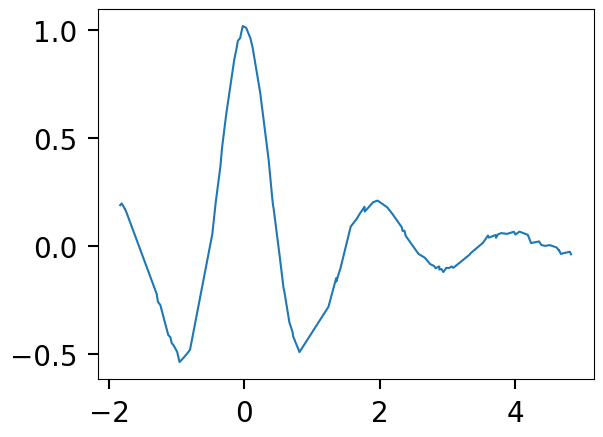

In [3]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)


n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)



ypred = print(regressor.predict(X.reshape(-1, 1)))

plt.plot(X,y)

In [38]:
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))

In [34]:

regressor.predict(X, return_std=True)

array([[-1.65766426],
       [-1.14449491],
       [-1.04868531],
       [-0.61443945],
       [-0.23285405],
       [ 0.21345007],
       [ 0.72030483],
       [ 1.23328256],
       [ 1.29135154],
       [ 2.25395391],
       [ 2.31820918],
       [ 3.83850918],
       [ 4.38174095],
       [ 4.72087531],
       [ 4.93414308]])